Day 1, afternoon session: MSM estimation and validation 
=====

<pre> 
Computational Molecular Biology Group, FU Berlin    </pre>

Basic imports:

In [1]:
import pyemma
import pyemma.coordinates as coor
import pyemma.plots as peplt
%pylab inline

You are still using msmtools from the deprecated Omnia channel. Please switch to conda-forge to catch future updates.
In order to do so please set conda-forge channel to highest priority by:

    conda config --add channels conda-forge

and update this package by:

    conda update msmtools


Populating the interactive namespace from numpy and matplotlib


/home/johnrobot/miniconda3/lib/python3.6/site-packages/pyemma/__init__.py:91: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.4, you have 2.3.2.
  .format(latest=latest, current=current), category=UserWarning)


In [2]:
print('PyEMMA version: ' + pyemma.__version__)

PyEMMA version: 2.3.2


Perform featurization and TICA (adjust as you found more optimal settings with Felix)

In [3]:
#Trajectory data and topology 
trajfile = 'data/bpti_ca_1ms_dt10ns.xtc'
topfile = 'data/bpti_ca.pdb'

# featurizer (all ca-alpha positions, input trajectory is superimposed to a common reference frame)
feat = coor.featurizer(topfile)
feat.add_all()

# Generate source object
inp = coor.source(trajfile, feat)

# Perform TICA and project trajectory features onto the first two TICs.
tica_obj = coor.tica(inp, lag=100, dim=2, kinetic_map=False)
Y = tica_obj.get_output()[0]


Let's check if the TICs look OK using a free energy plot:

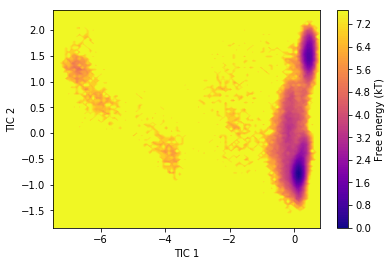

In [4]:
peplt.plot_free_energy(Y[:,0], Y[:,1], cmap = plt.cm.plasma)
xlabel('TIC 1')
ylabel('TIC 2')

Before we can estimate an MSM, we need to discretize our state-space into $N$ '_microstates_'. This is often done using different clustering techniques.  

### Clustering as a way to discrete MD trajectories 
PyEMMA has three different flavors of clustering built in which are typically the most useful for MSM building:
- k-means
- regular space clustering
- uniform time clustering 

explore these different clustering techniques using your TICA projection as input data:

### Example: Regular space clustering

In [8]:
print(Y)
print(len(Y))
print(len(Y[0]))

[[ 0.4006429   1.61836243]
 [ 0.49818844  1.28946066]
 [ 0.62591434  1.68482876]
 ..., 
 [-0.20039435 -0.20169926]
 [-0.23308393 -0.10288335]
 [-0.16675571  0.00613005]]
103125
2


In [5]:
# Regular-space clustering 
rscl = coor.cluster_regspace(data=Y, dmin=0.2)

#save cluster centers for visualization
cc_x_rs = rscl.clustercenters[:, 0]
cc_y_rs = rscl.clustercenters[:, 1]


Plotting cluster-centers on free energy plot from above:

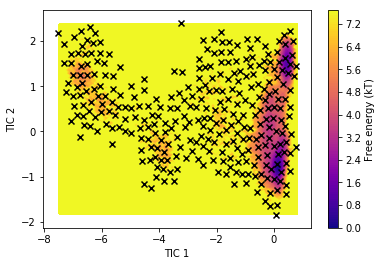

In [9]:
peplt.plot_free_energy(Y[:,0], Y[:,1], cmap = plt.cm.plasma)
scatter(cc_x_rs, cc_y_rs, marker = 'x', color = 'k')
xlabel('TIC 1')
ylabel('TIC 2')

### Try out the two other clustering techniques and try to vary the free parameters - how do they compare? Which one looks the best and why?

In [41]:
# K-means  clustering (use shift-tab to pull out the doc-string)
#clkm = coor.cluster_kmeans( fill me )
clkm_150 = coor.cluster_kmeans(Y,k=100,max_iter=50)
clkm = coor.cluster_kmeans(Y,max_iter=50)

#save cluster centers for visualization
cc_x_km_150 = clkm_150.clustercenters[:, 0]
cc_y_km_150 = clkm_150.clustercenters[:, 1]

cc_x_km = clkm.clustercenters[:, 0]
cc_y_km = clkm.clustercenters[:, 1]


22-05-17 16:52:16 pyemma.coordinates.clustering.kmeans.KmeansClustering[13] INFO     Cluster centers converged after 42 steps.
22-05-17 16:52:16 pyemma.coordinates.clustering.kmeans.KmeansClustering[14] INFO     The number of cluster centers was not specified, using min(sqrt(N), 5000)=321 as n_clusters.


22-05-17 16:52:29 pyemma.coordinates.clustering.kmeans.KmeansClustering[14] INFO     Cluster centers converged after 14 steps.


Visualize the clustercenters

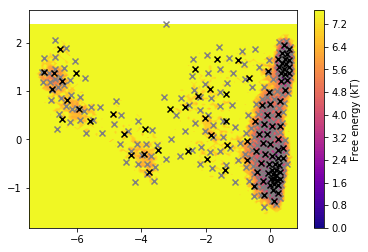

In [42]:
#print(cc_x_km.shape)
#print(cc_y_km.shape)
peplt.plot_free_energy(Y[:,0], Y[:,1], cmap=plt.cm.plasma)

scatter(cc_x_km, cc_y_km, marker='x',color='0.5')
scatter(cc_x_km_150, cc_y_km_150, marker='x',color='k')

And the final one:

In [43]:
# perform clustering
finalone_150=coor.cluster_uniform_time(Y,k=100)
finalone=coor.cluster_uniform_time(Y)

ut_x_km_150 = finalone_150.clustercenters[:, 0]
ut_y_km_150 = finalone_150.clustercenters[:, 1]

ut_x_km = finalone.clustercenters[:, 0]
ut_y_km = finalone.clustercenters[:, 1]

22-05-17 16:52:45 pyemma.coordinates.clustering.uniform_time.UniformTimeClustering[15] INFO     The number of cluster centers was not specified, using min(sqrt(N), 5000)=321 as n_clusters.


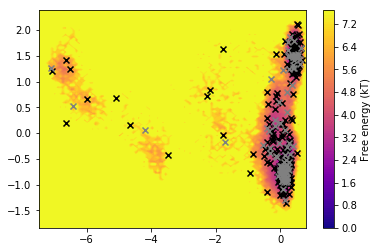

In [44]:
# visualize results
peplt.plot_free_energy(Y[:,0], Y[:,1],cmap=plt.cm.plasma)

scatter(ut_x_km, ut_y_km,marker='x',color='k')
scatter(ut_x_km_150, ut_y_km_150,marker='x',color='0.5')

When you have chosen your favorite clustering technique extract the discretized trajectories by filling in the questionmarks and executing the cell

In [45]:
dtrajs = clkm.dtrajs

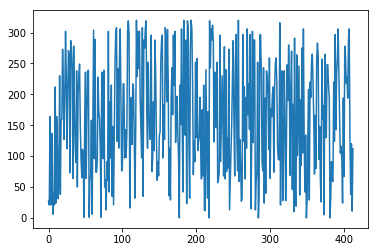

In [49]:
plot(np.concatenate(dtrajs)[::250])

MSM estimation
---------
Now that we have performed dimensionality reduction, clustering and obtained some discretized trajectories we can now  move on to the MSM estimation. For this part we will need to import the MSM part of PyEMMA to do all the hard work for us.


In [50]:
import pyemma.msm as msm

So as we saw earlier it is important to note the following two conditions to success in building Markov state models:

1. The state-space discretization. Essentially, how well our discretization resolves the dynamics of the system.
2. The lag time: the time interval at which we count state transitions.

An appropriate choice of the lag-time is also critical. Often a range of different lag-times are tried out and a plot of the _implied timescales_ or _charateristic timescales_ or _relaxation timescales_ is performed. PyEMMA does this for us:

In [52]:
# Some range of possible lag-times we want to try
lags = [1,2,5,10,20,50,100,200]
# Compute implied time-scales:
its = msm.its(dtrajs, lags=lags)

This function estimates an MSM for each of the lag-times we have provided: $\tau=n_{lag}\cdot t_{\text{stride}}$ Where $n_{lag}$ is one of the integers given in the lags list, and  $t_{\text{stride}}$ is the trajectory time-stride. For the example data given here (BPTI) the last parameter is $10\,\mathrm{ns}$. The implied-timescales are then computed as:
   $$ t_i = \frac{-\tau}{\ln | \lambda_i(\tau) |}.$$
The its object contains these implied time-scales which can be plotted using one of PyEMMAs built in function for quick inspection - here you can also defined the time-units to ensure the axes express physical time:

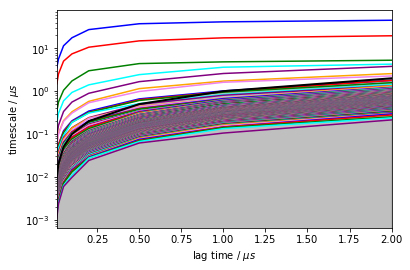

In [53]:
peplt.plot_implied_timescales(its, units=r'$\mu s$', dt=0.01 )

It has been shown that the implied timescales (y-axis) should be independent of the lag time (x-axis) [3]. For short lag times this is not the case, but after about 1 microsecond, they are fairly constant. Some of the faster timescales (lower value on y-axis) either still increase as a function of lag-time or fall below the grey shaded area in the plot. This is often the case and is due to a combination of numerical issues and an imperfect discretization - this mean that the processes associated with these time-scales will be unreliable. The grey area defines the lag-time of the model, and therefore also the time-resolution of what can be resolved. If the processess fall within this area, they are generally not resolved.

Basically - we have to make a compromise, we want to have the model which the highest time-resolution which still has implied time-scales which are lag-time independent.

Sometimes it can be useful to quantify the uncertainty of these time-scales, to get a better idea of any changes in the implied-timescales carry any statistical significance. 
### using the docstring of the its-function, try to figure out how to obtain Bayesian error estimates of the implied time-scales


In [54]:
its_bayes = msm.its(dtrajs, lags=lags, nits=10, errors='bayes')

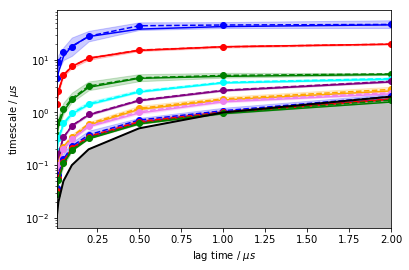

In [55]:
#Visualize
peplt.plot_implied_timescales(its_bayes, units=r'$\mu s$', dt=0.01 )


We can now quite confidently say that the slowest time-scales are converged at at the $1\,\mu s$ mark (100 steps).

MSM
---
Now we can finally estimate a Markov model. This was happening behind the scenes above, but now we construct an msm instance which allows us to take a closer look at the model. We just need to dust-off our discretized trajectories from above and PyEMMA will take care of the rest:

In [56]:
M = msm.estimate_markov_model(dtrajs, 100)

The Markov model will be constructed on the largest connected set of states. That could mean that we exclude some states from the analysis. Let us verify that this is not the case here:

In [57]:
print ('fraction of states used = ', M.active_state_fraction)
print ('fraction of counts used = ', M.active_count_fraction)

fraction of states used =  1.0
fraction of counts used =  1.0


Validation - Chapman-Kolmogorov test
-----------

Let's see if our Markov model fulfill the Chapman-Kolmogorov equation. This is a way of testing the self-consistency of the model. There will be more background this tomorrow morning.

The MSM instance has a method to make the testing very easy:

In [58]:
ckt = M.cktest(3)

We can now plot the results

(<matplotlib.figure.Figure at 0x7fe215137fd0>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe2151a7518>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x7fe2ac46f048>]], dtype=object))

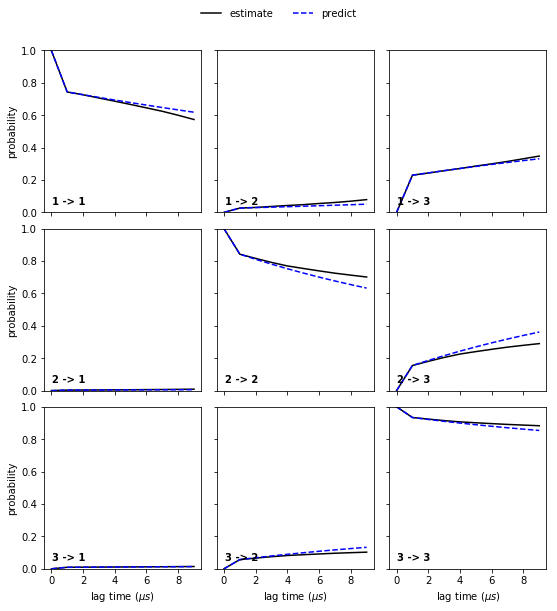

In [59]:
peplt.plot_cktest(ckt,dt=0.01,units=r"$\mu s$")

What is shown here is the predicted transition probabilities from the Markov model (blue) and corresponding ones estimated directly from the data you used to estimate the Markov model (that is, training a Markov model with a larger lag-time). More formally what we check is whether the following relation is approximately fulfilled:
$$ \underbrace{T^k(\tau)}_{\text{Markov model prediction}} \approx \underbrace{T(k\tau)}_{\text{estimation from data}} $$
where $k$ is some positive integer, and $T(\cdot)$ is a transition probability matrix for a given lag-time. Basically, we want to ensure these lines are as close as possible to each other. More depth on this topic is given tomorrow morning.


### Let's Play
1. Estimate a Markov model with a different lag-time and/or a different clustering method. When does the CK-test break down?
2. Repeat this for a Bayesian MSM.
3. Try to compare results using the non-reversible MSM estimators
4. Generate trajectories using the msm object. Take a look at the PyEMMA homepage and try to get familiar with the documentation to do this.

In [77]:
#M = msm.estimate_markov_model(dtrajs, 50, reversible=False)
M_bayes = msm.bayesian_markov_model(dtrajs, 100)

In [78]:
print ('fraction of states used = ', M.active_state_fraction)
print ('fraction of counts used = ', M.active_count_fraction)

fraction of states used =  1.0
fraction of counts used =  1.0


Validation - Chapman-Kolmogorov test
-----------

Let's see if our Markov model fulfill the Chapman-Kolmogorov equation. This is a way of testing the self-consistency of the model. There will be more background this tomorrow morning.

The MSM instance has a method to make the testing very easy:

In [81]:
#ckt = M_bayes.cktest(3)
ckt = M_bayes.cktest(3)

We can now plot the results

(<matplotlib.figure.Figure at 0x7fe1f73e6080>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe1f73dd550>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x7fe1f70945f8>]], dtype=object))

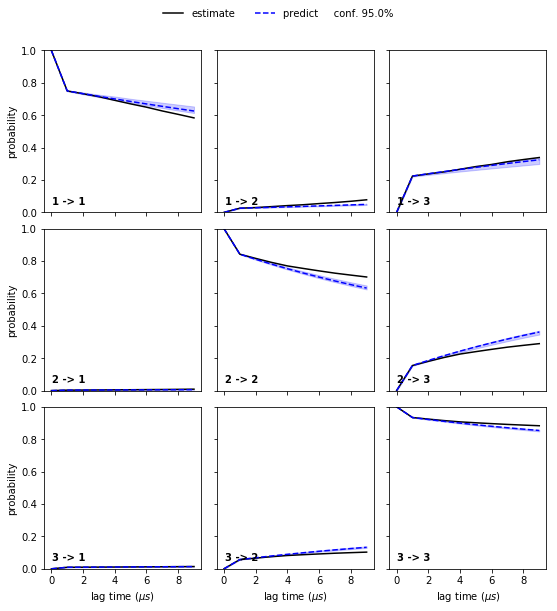

In [82]:
peplt.plot_cktest(ckt,dt=0.01,units=r"$\mu s$")

Let's Play
-------
1. Estimate a Markov model with a different lag-time and/or a different clustering method. When does the CK-test break down?
2. Repeat this for a Bayesian MSM. 
3. Try to compare results using the non-reversible MSM estimators (hint: set reversible-flag to False)
4. Generate trajectories using the msm object. Take a look at the PyEMMA homepage and try to get familiar with the documentation to do this.

References
------

1. Shaw DE, Maragakis P, Lindorff-Larsen K, Piana S, Dror RO, Eastwood MP, Bank JA, Jumper JM, Salmon JK, Shan Y,
Wriggers W: Atomic-level characterization of the structural dynamics of proteins.
*Science* **330**:341-346 (2010). doi: 10.1126/science.1187409.
2. Pérez-Hernández, G. and Paul, F. and Giorgino, T. and de Fabritiis, G. and Noé, F. Identification of slow molecular order parameters for Markov model construction. *J. Chem. Phys.* **139**:015102 (2013)
3. Swope WC, Pitera JW and Suits F. Describing protein folding kinetics by molecular dynamics simulations: 1. Theory. 
*J. Phys. Chem. B* **108**:6571-6581 (2004)
4. Susanna Röblitz Marcus Weber: Fuzzy spectral clustering by PCCA+: application to Markov state models and data classification. Adv Data Anal Classif (2013), DOI 10.1007/s11634-013-0134-6
5. Noé F, Doose S, Daidone I, Löllmann M, Chodera JD, Sauer M, Smith JC. Dynamical fingerprints for probing individual relaxation processes in biomolecular dynamics with simulations and kinetic experiments. *Proc. Natl. Acad. Sci. USA*, **108**: 4822-4827 (2011)
6. Metzner P, Schütte C, Vanden-Eijnden, E. Transition Path Theory for Markov Jump Processes. *Multiscale Model. Simul.* **7**. 1192--1219 (2009)
7. Noé F, Schütte C, Vanden-Eijnden E, Reich L and Weikl T. Constructing the Full Ensemble of Folding Pathways from Short Off-Equilibrium Simulations. *Proc. Natl. Acad. Sci. USA*, **106**:19011-19016 (2009)